In [1]:
import os
import re
import glob
import pickle
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import zoom
from pathlib import Path
from alive_progress import alive_it
from matplotlib.colors import LinearSegmentedColormap

from walrus_workshop.walrus import get_trajectory

In [2]:
# Settings
traj_id = 29
data_id = "shear_flow"

In [3]:
# Load the enstrophy and trajectory
trajectory, metadata = get_trajectory(dataset_id=data_id, trajectory_id=traj_id, split='test')
print(trajectory.keys())

file_list = glob.glob(os.path.join("metrics", "enstrophy", data_id, f"{data_id}_{traj_id}_*.csv"))
print(f"Found {len(file_list)} files")
df_enstrophy = pl.read_csv(file_list[0])
df_enstrophy.head()

dict_keys(['input_fields', 'output_fields', 'constant_scalars', 'boundary_conditions', 'space_grid', 'input_time_grid', 'output_time_grid', 'padded_field_mask', 'field_indices', 'metadata', 'extra_metadata'])
Found 1 files


enstrophy
f64
0.483724
0.019464
0.040221
0.085748
0.176617


In [4]:
# Load in the sae feature values
file_list = glob.glob(os.path.join("sae", "top_enstrophy", f"*traj_{traj_id}*.pkl"))
file_list = sorted(file_list)
print(f"Found {len(file_list)} files")

df = None
for file in alive_it(file_list, force_tty=True):
    # Use re to find the file number
    file_stem = Path(file).stem
    match = re.search(r"file_(\d+)", file_stem)
    if match:
        file_idx = int(match.group(1))
    else:
        raise ValueError(f"No file number found in {file_stem}")
    
    # Read in the data
    with open(file, "rb") as f:
        data = pickle.load(f)
    if df is None:
        df = {"batch_id": [], "feature_value": [], "feature_id": [], "file_id": []}
    for feature_idx in range(len(data["features"])):
        # Filter for features > 0
        mask = data["features"][feature_idx][0] > 0
        if mask.sum() > 0:
            df["batch_id"] += data["features"][feature_idx][1][mask].tolist()
            df["feature_value"] += data["features"][feature_idx][0][mask].tolist()
            df["feature_id"] += [feature_idx] * len(
                data["features"][feature_idx][1][mask]
            )
            df["file_id"] += [file_idx] * len(data["features"][feature_idx][1][mask])

df = pl.DataFrame(df)
# Count how many time each feature id (in the SAE)
df_feature_counts = df["feature_id"].value_counts().sort(by="count", descending=True)
# Aggregae over the SAE feature to get the max value, join on the count
df_feature_agg = (
    df.group_by("feature_id")
    .agg(pl.col("feature_value").max().alias("max_feature_value"))
    .sort(by="max_feature_value", descending=True)
    .join(df_feature_counts, on="feature_id", how="left")
)
df_feature_agg = (
    df.group_by("feature_id")
    .agg(pl.col("feature_value").median().alias("median_feature_value"))
    .join(df_feature_agg, on="feature_id", how="left")
)

print(df.shape)
print(df.head())


Found 33 files
|████████████████████████████████████████| 33/33 [100%] in 16.5s (1.98/s)       
(3376332, 4)
shape: (5, 4)
┌──────────┬───────────────┬────────────┬─────────┐
│ batch_id ┆ feature_value ┆ feature_id ┆ file_id │
│ ---      ┆ ---           ┆ ---        ┆ ---     │
│ i64      ┆ f64           ┆ i64        ┆ i64     │
╞══════════╪═══════════════╪════════════╪═════════╡
│ 401      ┆ 0.015096      ┆ 2          ┆ 0       │
│ 385      ┆ 0.014914      ┆ 2          ┆ 0       │
│ 353      ┆ 0.0131        ┆ 2          ┆ 0       │
│ 369      ┆ 0.012874      ┆ 2          ┆ 0       │
│ 1        ┆ 0.011436      ┆ 2          ┆ 0       │
└──────────┴───────────────┴────────────┴─────────┘


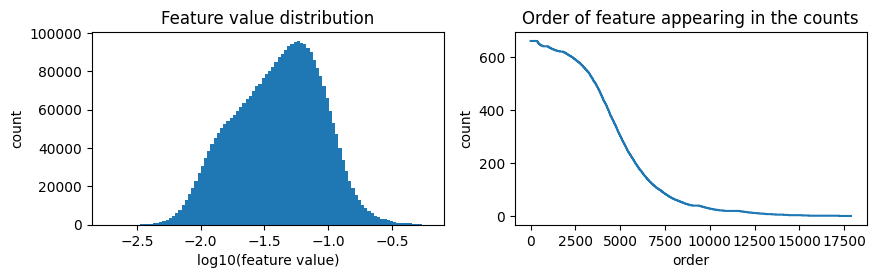

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 2.5))
axes[0].hist(np.log10(df["feature_value"]), bins=100)
axes[0].set_xlabel("log10(feature value)")
axes[0].set_ylabel("count")
axes[0].set_title("Feature value distribution")
axes[1].plot(df_feature_counts["count"])
axes[1].set_xlabel("order")
axes[1].set_ylabel("count")
axes[1].set_title("Order of feature appearing in the counts")
plt.show()

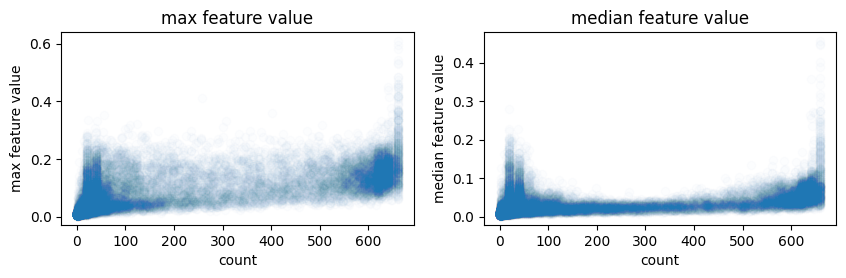

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 2.5))
axs[0].scatter(df_feature_agg["count"], df_feature_agg["max_feature_value"], alpha=0.01)
axs[0].set_xlabel("count")
axs[0].set_ylabel("max feature value")
axs[0].set_title("max feature value")
axs[1].scatter(df_feature_agg["count"], df_feature_agg["median_feature_value"], alpha=0.01)
axs[1].set_xlabel("count")
axs[1].set_ylabel("median feature value")
axs[1].set_title("median feature value")
plt.show()


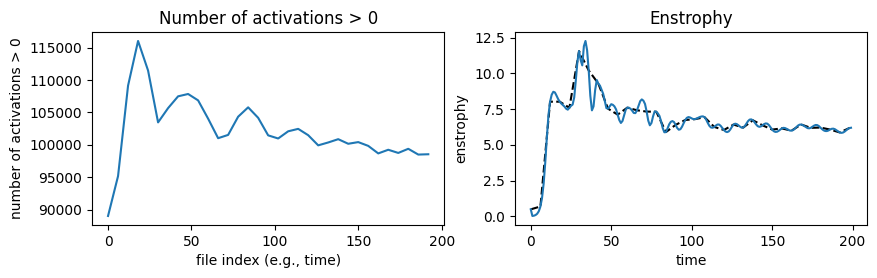

In [7]:
counts = df["file_id"].value_counts().sort(by='file_id', descending=False)
fig, axs = plt.subplots(1, 2, figsize=(10, 2.5))
axs[0].plot(6 * counts["file_id"], counts["count"])
axs[0].set_title("Number of activations > 0")
axs[0].set_xlabel("file index (e.g., time)")
axs[0].set_ylabel("number of activations > 0")

axs[1].plot(np.arange(len(df_enstrophy))[::6], df_enstrophy["enstrophy"][::6], "k--")
axs[1].plot(np.arange(len(df_enstrophy)), df_enstrophy["enstrophy"])
axs[1].set_title("Enstrophy")
axs[1].set_xlabel("time")

axs[1].set_ylabel("enstrophy")
plt.show()

Text(0.5, 1.0, 'Enstrophy')

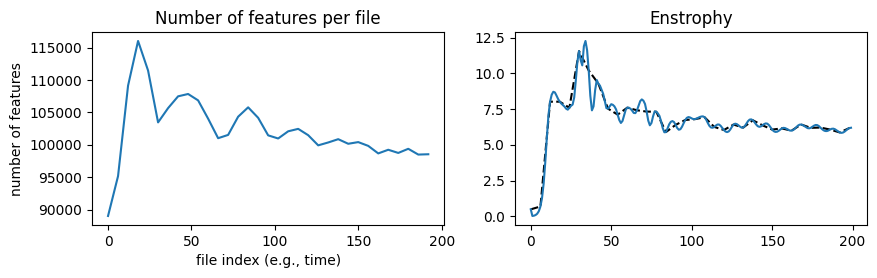

In [8]:
counts = df.group_by("file_id").agg(pl.col("feature_id").count().alias("n_features")).sort("file_id")
fig, axs = plt.subplots(1, 2, figsize=(10, 2.5))
axs[0].plot(6 * counts["file_id"], counts["n_features"])
axs[0].set_title("Number of features per file")
axs[0].set_xlabel("file index (e.g., time)")
axs[0].set_ylabel("number of features")

axs[1].plot(np.arange(len(df_enstrophy))[::6], df_enstrophy["enstrophy"][::6], "k--")
axs[1].plot(np.arange(len(df_enstrophy)), df_enstrophy["enstrophy"])
axs[1].set_title("Enstrophy")

Text(0.5, 1.0, 'Enstrophy')

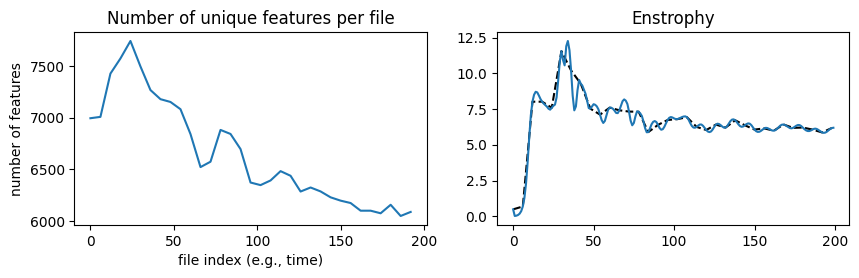

In [9]:
counts = df.group_by("file_id").agg(pl.col("feature_id").n_unique().alias("n_features")).sort("file_id")
fig, axs = plt.subplots(1, 2, figsize=(10, 2.5))
axs[0].plot(6 * counts["file_id"], counts["n_features"])
axs[0].set_title("Number of unique features per file")
axs[0].set_xlabel("file index (e.g., time)")
axs[0].set_ylabel("number of features")

axs[1].plot(np.arange(len(df_enstrophy))[::6], df_enstrophy["enstrophy"][::6], "k--")
axs[1].plot(np.arange(len(df_enstrophy)), df_enstrophy["enstrophy"])
axs[1].set_title("Enstrophy")

/tmp/ipykernel_1998463/1899887422.py:12: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  feature_values = df.filter(pl.col("feature_id").is_in(feature_ids))["feature_value"]


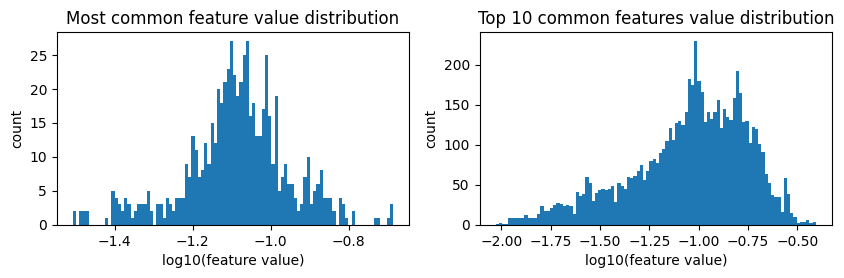

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 2.5))
# get the feature that appears the most
feature_id = df_feature_counts[0]['feature_id']
# make a histrogram of the feature's values
feature_values = df.filter(pl.col("feature_id") == feature_id)["feature_value"]
axs[0].hist(np.log10(feature_values), bins=100)
axs[0].set_xlabel("log10(feature value)")
axs[0].set_ylabel("count")
axs[0].set_title("Most common feature value distribution")
# get the 10 features that appear the most
feature_ids = df_feature_counts.head(10)["feature_id"]
feature_values = df.filter(pl.col("feature_id").is_in(feature_ids))["feature_value"]
axs[1].hist(np.log10(feature_values), bins=100)
axs[1].set_xlabel("log10(feature value)")
axs[1].set_ylabel("count")
axs[1].set_title("Top 10 common features value distribution")
plt.show()

In [21]:
df.head()

batch_id,feature_value,feature_id,file_id
i64,f64,i64,i64
401,0.015096,2,0
385,0.014914,2,0
353,0.0131,2,0
369,0.012874,2,0
1,0.011436,2,0


In [30]:
feature_values

batch_id,feature_value,feature_id,file_id
i64,f64,i64,i64
5388,0.609714,5328,11
5404,0.607657,5328,11
4299,0.522138,5328,11
4315,0.521561,5328,11
4332,0.514688,5328,11
…,…,…,…
4427,0.483184,5328,11
3451,0.472733,5328,11
5516,0.471728,5328,11


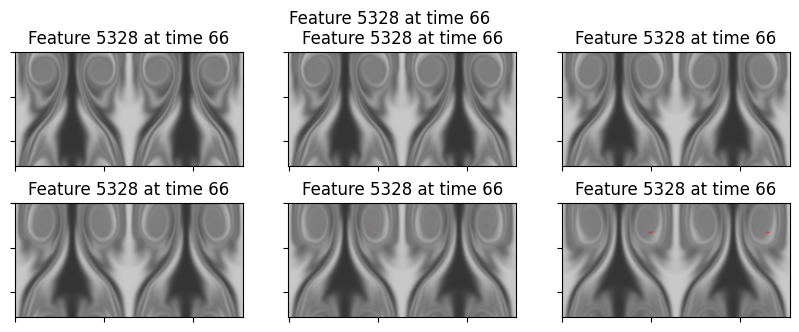

In [ ]:
feature = df.sort(by="feature_value", descending=True)[0]
t = feature["file_id"] * 6
selected_features = df.filter(pl.col("file_id") == feature["file_id"]).filter(pl.col("feature_id") == feature["feature_id"])
shape = (6, 32, 32) # see script_activations.py
batch_locations = np.unravel_index(selected_features["batch_id"].to_numpy(), shape)

mask_colors = [(1, 0, 0, 0), (1, 0, 0, 0.6)]  # transparent to semi-transparent red
mask_cmap = LinearSegmentedColormap.from_list('mask', mask_colors)

field_index = 0
simulation_chunk = trajectory['input_fields'][0,t.item()-5:t.item()+1, :, :, field_index].numpy()

vmin = np.min(simulation_chunk)
vmax = np.max(simulation_chunk)
mmin = np.min(selected_features["feature_value"].to_numpy())
mmax = np.max(selected_features["feature_value"].to_numpy())

fig, axs = plt.subplots(2, 3, figsize=(10, 2 * 1.8))
for i in range(simulation_chunk.shape[0]):
    # simulation
    snapshot = simulation_chunk[i, :, :, field_index]
    # input_field = trajectory['input_fields'][time_index]
    axs[i//3, i%3].imshow(snapshot, vmin=vmin, vmax=vmax, cmap='gray')
    # # Overlay the mask
    batch_mask = (batch_locations[0] == i)   
    batch_feature_values = selected_features['feature_value'].to_numpy()[batch_mask]
    feature_map = np.zeros((32,32))
    feature_map[batch_locations[1][batch_mask], batch_locations[2][batch_mask]] = batch_feature_values
    # feature_map[batch_locations[1], batch_locations[2]] = feature_values["feature_value"]    
    im2 = axs[i//3, i%3].imshow(zoom(feature_map, (8, 16)), cmap=mask_cmap, vmin=mmin, vmax=mmax)

    axs[i//3, i%3].set_yticklabels([])
    axs[i//3, i%3].set_xticklabels([])

plt.suptitle(f"Feature {feature['feature_id'][0]} at time {t.item()}")
plt.show()

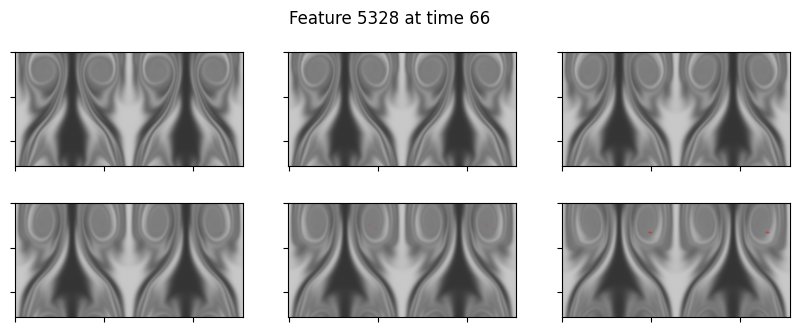

In [33]:
# Filter for SAE feature with top value
def show_sorted_feature(index):
    feature = df.sort(by="feature_value", descending=True)[index]
    t = feature["file_id"] * 6
    selected_features = df.filter(pl.col("file_id") == feature["file_id"]).filter(pl.col("feature_id") == feature["feature_id"])
    shape = (6, 32, 32) # see script_activations.py
    batch_locations = np.unravel_index(selected_features["batch_id"].to_numpy(), shape)

    mask_colors = [(1, 0, 0, 0), (1, 0, 0, 0.6)]  # transparent to semi-transparent red
    mask_cmap = LinearSegmentedColormap.from_list('mask', mask_colors)

    field_index = 0
    simulation_chunk = trajectory['input_fields'][0,t.item()-5:t.item()+1, :, :, field_index].numpy()

    vmin = np.min(simulation_chunk)
    vmax = np.max(simulation_chunk)
    mmin = np.min(selected_features["feature_value"].to_numpy())
    mmax = np.max(selected_features["feature_value"].to_numpy())

    fig, axs = plt.subplots(2, 3, figsize=(10, 2 * 1.8))
    for i in range(simulation_chunk.shape[0]):
        # simulation
        snapshot = simulation_chunk[i, :, :, field_index]
        # input_field = trajectory['input_fields'][time_index]
        axs[i//3, i%3].imshow(snapshot, vmin=vmin, vmax=vmax, cmap='gray')
        # # Overlay the mask
        batch_mask = (batch_locations[0] == i)   
        batch_feature_values = selected_features['feature_value'].to_numpy()[batch_mask]
        feature_map = np.zeros((32,32))
        feature_map[batch_locations[1][batch_mask], batch_locations[2][batch_mask]] = batch_feature_values
        # feature_map[batch_locations[1], batch_locations[2]] = feature_values["feature_value"]    
        im2 = axs[i//3, i%3].imshow(zoom(feature_map, (8, 16)), cmap=mask_cmap, vmin=mmin, vmax=mmax)

        axs[i//3, i%3].set_yticklabels([])
        axs[i//3, i%3].set_xticklabels([])

    plt.suptitle(f"Feature {feature['feature_id'][0]} at time {t.item()}")
    plt.show()
show_sorted_feature(0)


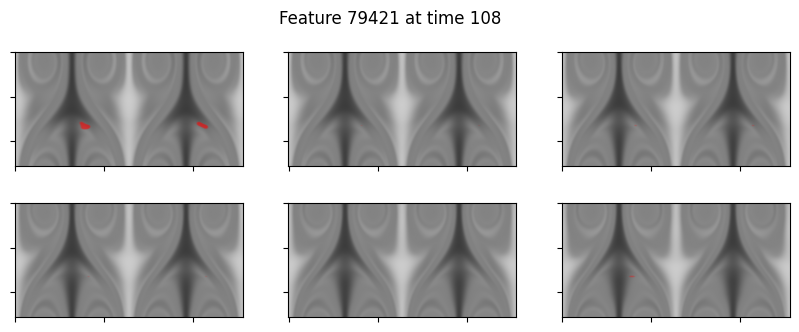

In [34]:
show_sorted_feature(3)

/tmp/ipykernel_1998463/3983484465.py:8: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  selected_features = df.filter(pl.col("file_id").is_in(file_features["file_id"])).filter(pl.col("feature_id").is_in(file_features["feature_id"]))


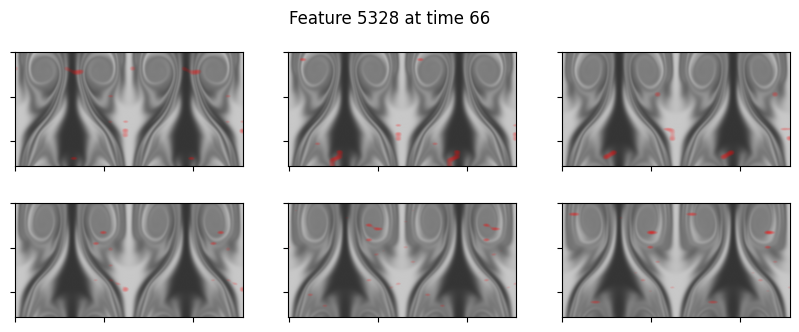

In [37]:
# Filter for SAE feature with top value and then top N at that time
show_n_features = 75
main_feature = df.sort(by="feature_value", descending=True)[0]
t = main_feature["file_id"][0] * 6
file_features = df.filter(pl.col("file_id") == main_feature["file_id"][0]).sort(by="feature_value", descending=True).head(show_n_features)
assert len(file_features) == show_n_features
assert file_features["file_id"].n_unique() == 1
selected_features = df.filter(pl.col("file_id").is_in(file_features["file_id"])).filter(pl.col("feature_id").is_in(file_features["feature_id"]))
# selected_features = df.filter(pl.col("file_id") == feature["file_id"]).filter(pl.col("feature_id") == feature["feature_id"]).is_in(file_features["file_id"])
shape = (6, 32, 32) # see script_activations.py
batch_locations = np.unravel_index(selected_features["batch_id"].to_numpy(), shape)
mask_colors = [(1, 0, 0, 0), (1, 0, 0, 0.6)]  # transparent to semi-transparent red
mask_cmap = LinearSegmentedColormap.from_list('mask', mask_colors)

field_index = 0
simulation_chunk = trajectory['input_fields'][0,t-5:t+1, :, :, field_index].numpy()

vmin = np.min(simulation_chunk)
vmax = np.max(simulation_chunk)
mmin = np.min(selected_features["feature_value"].to_numpy())
mmax = np.max(selected_features["feature_value"].to_numpy())

fig, axs = plt.subplots(2, 3, figsize=(10, 2 * 1.8))
for i in range(simulation_chunk.shape[0]):
    # simulation
    snapshot = simulation_chunk[i, :, :, field_index]
    # input_field = trajectory['input_fields'][time_index]
    axs[i//3, i%3].imshow(snapshot, vmin=vmin, vmax=vmax, cmap='gray')
    # # Overlay the mask
    batch_mask = (batch_locations[0] == i)   
    batch_feature_values = selected_features['feature_value'].to_numpy()[batch_mask]
    feature_map = np.zeros((32,32))
    feature_map[batch_locations[1][batch_mask], batch_locations[2][batch_mask]] = batch_feature_values
    # feature_map[batch_locations[1], batch_locations[2]] = feature_values["feature_value"]    
    im2 = axs[i//3, i%3].imshow(zoom(feature_map, (8, 16)), cmap=mask_cmap, vmin=mmin, vmax=mmax)

    axs[i//3, i%3].set_yticklabels([])
    axs[i//3, i%3].set_xticklabels([])

plt.suptitle(f"Feature {feature['feature_id'][0]} at time {t}")
plt.show()


In [15]:
# # Filter for SAE feature with top value
# feature = df.sort(by="feature_value", descending=True)[0]
# t = feature["file_id"] * 6
# feature_values = df.filter(pl.col("file_id") == feature["file_id"]).filter(pl.col("feature_id") == feature["feature_id"])
# shape = (6, 32, 32) # see script_activations.py
# batch_locations = np.unravel_index(feature_values["batch_id"].to_numpy(), shape)

In [16]:
# fig, axs = plt.subplots(2, 3, figsize=(10, 2 * 2.5))
# for i in range(6):
#     batch_feature_values = feature_values.to_numpy()[batch_locations[0] == i]
#     feature_map = np.zeros((32,32))
#     feature_map[batch_locations[1].astype(int), batch_locations[2].astype(int)] = feature_values["feature_value"]
#     axs[i//3, i%3].imshow(feature_map)
# plt.show()